# **Avance del código para el Modelo de ML para la Clasificación de Imágenes: Frutas y Verduras**
**Curso:** Taller de Construcción de Software Móvil

**Proyecto:** FitBite

**Grupo:** 1

**Integrantes:**

- Abanto Salas, Flavia Francesca
- Domínguez Matos, Juan Martín
- Palacios Barrutia, Jeanpiere Julian

## **1. Importe de librerías**

Se importan librerías relacionadas al reconocimiento de imágenes, Machine Learning y métricas. Entre ellas, destacan:
* Torchvision
* Matplotlib (heatmap)
* Os (acceso al directorio del conjunto de datos)
* sklearn.metrics (accuracy_score)

In [1]:
from torchvision import transforms, datasets
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import imshow
import os
from sklearn.metrics import accuracy_score

## **2. Algoritmo de clasificación basado en Softmax**

Uso de Softmax para poder clasificar imágenes a partir de etiquetas categóricas (que vienen a ser, los nombres de las frutas y verduras consideradas en nuestro dataset).

Aquí, se muestra una función para iniciar con las épocas dado los parámetros mostrados.

In [2]:
softmax = nn.Softmax(dim=-1)
def run_epoch(model, loss_func, data_loader, device, optimizer=None, score_funcs=None):
    running_loss = 0.0 #valor de pérdida de la época
    scores = dict() # guardará los resultados de score de las funciones
    if score_funcs is not None:
        score = {str(i): [] for i in score_funcs.keys()}
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_hat = model(inputs)
        loss = loss_func(y_hat, labels)
        if model.training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if score_funcs is not None:
            y_hat_soft = softmax(y_hat.cpu())
            y_pred = [np.argmax(y_hat_soft[i,:]) for i in range(len(labels))]
            for i in score_funcs.keys():
                score[str(i)].append(score_funcs[i](labels.tolist(), y_pred))
        running_loss += loss.item()
    if score_funcs is not None:
        scores = {i: sum(score[i])/len(score[i]) for i in score_funcs.keys()}
    return running_loss, scores

## **3. Función para entrenar la red**

Asimismo, se creó una función para cargar la red neuronal. Dentro de esta, se obtiene el valor de pérdida (losses) y los scores obtenidos.

In [3]:
def train_network(model, loss_func, training_loader, optimizer, lr_schedule, 
    score_funcs=None, testing_loader=None, val_loader=None, epochs=20, device="cpu",\
    checkpoint_file=None):
    model.to(device)
    losses = []
    scores = None #store the dict of scores
    for epoch in tqdm(range(epochs), desc="Epoch", position=0):
        model = model.train()
        losses.append(run_epoch(model, loss_func, training_loader, device, \
            optimizer=optimizer)[0])
        if lr_schedule is not None:
            if isinstance(lr_schedule, torch.optim.lr_scheduler.ReduceLROnPlateau) \
                and val_loader is not None:
                model.eval()
                with torch.no_grad():
                    eval_loss = run_epoch(model, loss_func, val_loader, device)[0]
                lr_schedule.step(eval_loss)
            else:
                lr_schedule.step()
    if score_funcs is not None and testing_loader is not None:
        model = model.eval()
        with torch.no_grad():
            scores = run_epoch(model, loss_func, testing_loader, device, score_funcs=score_funcs)[1]
    if checkpoint_file is not None:
        torch.save({'model': model, 'model_state_dict':model.state_dict(), \
            'optimizer_state_dict': optimizer.state_dict()}, checkpoint_file)
    return losses, scores

## **4. Redimensionamiento de imágenes y ruta de las carpetas de entrenamiento (train) y prueba (test)**

Todas las imágenes se redimensionan (224,224). Además, se recurre a la rotación y traslación de las imágenes del dataset para la clasificación de imágenes.

Nótese que para las variables *train_img_path* y *test_img_path*, se han agregado como String las rutas de donde se encuentran las carpetas de entrenamiento (train) y prueba (test).

In [5]:
img_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=45),
    transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.ToTensor()])
    
img_basic_transform = transforms.Compose([transforms.Resize((224, 224)),
    transforms.ToTensor()])
    
train_img_path = "./drive/MyDrive/_v2frutas_verduras/train"
train_dataset_n = datasets.ImageFolder(train_img_path, transform=img_basic_transform)
train_dataset_t = datasets.ImageFolder(train_img_path, transform=img_transforms)
train_dataset = torch.utils.data.ConcatDataset([train_dataset_n, train_dataset_t])
test_img_path = "./drive/MyDrive/_v2frutas_verduras/test"
test_dataset = datasets.ImageFolder(test_img_path, transform=img_basic_transform)

In [6]:
class ResidualBlockE(nn.Module):
    def __init__(self, channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        self.F = nn.Sequential(nn.Conv2d(channels, channels, kernel_size, 
            padding=pad),nn.BatchNorm2d(channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(channels, channels, kernel_size, padding=pad),
            nn.BatchNorm2d(channels),nn.LeakyReLU(leak_rate))
    def forward(self, x):
        return x + self.F(x)

In [7]:
class ResidualBottleNeck(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, leak_rate=0.1):
        super().__init__()
        pad = (kernel_size-1)//2
        bottleneck = out_channels//4 #tune this later
        self.F = nn.Sequential(nn.BatchNorm2d(in_channels), nn.LeakyReLU(leak_rate),
            nn.Conv2d(in_channels, bottleneck, 1, padding=0),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, bottleneck, kernel_size, padding=pad),
            nn.BatchNorm2d(bottleneck),nn.LeakyReLU(leak_rate),
            nn.Conv2d(bottleneck, out_channels, 1, padding=0))
        self.shortcut = nn.Identity()
        if in_channels != out_channels:
            self.shortcut = nn.Sequential(nn.Conv2d(in_channels, out_channels, 1, padding=0), \
                nn.BatchNorm2d(out_channels))
    def forward(self, x):
        return self.shortcut(x) + self.F(x)

## **5. Análisis de datos**

Se muestran imágenes correspondientes a algunas clases de nuestro dataset.

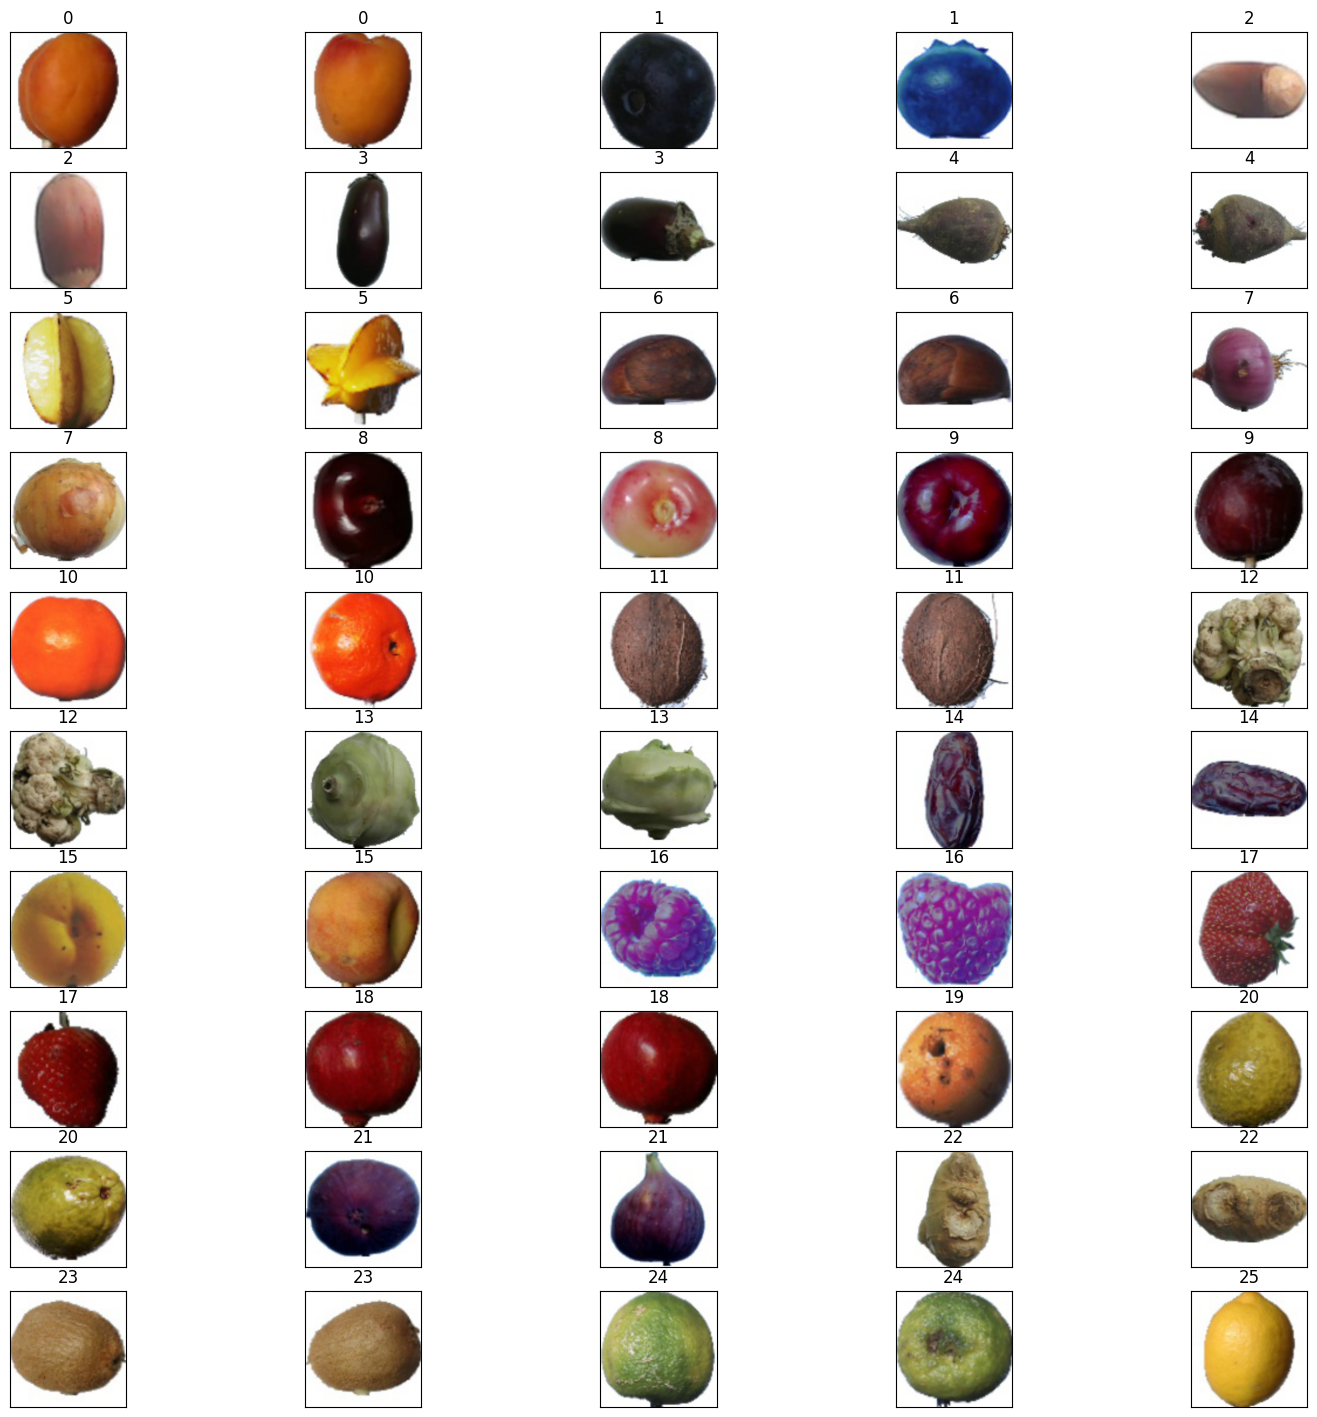

In [8]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(16, 14), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    x_example, y_example = train_dataset[i*100]
    ax.imshow(x_example.permute(1, 2, 0))
    ax.set_title(y_example, fontsize = 12)
plt.tight_layout(pad=0.1)
plt.show()

Se muestra cómo está distribuida numéricamente las imágenes de cada clase. Se nota que, se cuenta con igual número de imágenes (195) para cada clase (las 49).

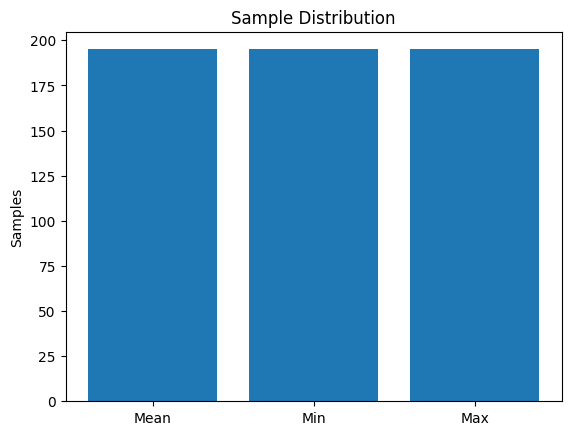

In [9]:
from collections import Counter
t = train_dataset_n.targets
label_counts = Counter(t).values()
classes = train_dataset_n.classes
plt.bar(["Mean", "Min", "Max"], [np.mean(list(label_counts)), min(label_counts), max(label_counts)])
plt.ylabel("Samples")
plt.title("Sample Distribution")
plt.show()

## **6. Entrenamiento**

Código correspondiente al entrenamiento del modelo.

In [10]:
device = torch.device("cuda")
B = 32
train_loader = DataLoader(train_dataset, batch_size=B, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=B)
D = 224*224 #28px * 28px
C = 3 #rgb
classes = len(os.listdir("./drive/MyDrive/_v2frutas_verduras/train"))
kernel_size = 3
n_filters = 15
leak_rate = 0.15

In [11]:
cnn_res_model = nn.Sequential(ResidualBottleNeck(C, n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.MaxPool2d((2,2)), ResidualBlockE(n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBottleNeck(n_filters, 2*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.MaxPool2d((2,2)), ResidualBlockE(2*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBottleNeck(2*n_filters, 4*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), ResidualBlockE(4*n_filters, kernel_size),
    nn.LeakyReLU(leak_rate), nn.Flatten(), nn.Linear(D*n_filters//4, classes))

In [12]:
loss_func = nn.CrossEntropyLoss()
score_funcs={'Acc':accuracy_score}
T = 6
optimizer = torch.optim.SGD(cnn_res_model.parameters(), lr=0.0003, momentum=0.9, nesterov=True)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,  T//2 ,eta_min=0.0001)
losses = train_network(cnn_res_model, loss_func, train_loader, optimizer, 
    scheduler, score_funcs, test_loader, epochs=T, device="cuda", checkpoint_file='best_acc.pt')

Epoch: 100%|██████████| 6/6 [45:49<00:00, 458.23s/it]


## **7. Evaluación del modelo**

In [13]:
checkpoint_dict = torch.load('best_acc.pt', map_location="cuda")
cnn_res_model.load_state_dict(checkpoint_dict['model_state_dict'])

<All keys matched successfully>

Código para validación del modelo.

In [14]:
val_img_path = "./drive/MyDrive/_v2frutas_verduras/validation"
val_dataset = datasets.ImageFolder(val_img_path, transform=img_basic_transform)
true_labels = []
predicted_labels = []
misclassified = []
features = []
label_ids = []
with torch.no_grad():
    cnn_res_model.to(device)
    cnn_res_model.eval()
    for image, label in val_dataset:
        logits = cnn_res_model(image.unsqueeze(0).to(device))
        features.append(logits.squeeze().detach().cpu().numpy())
        y_hat = softmax(logits.cpu())
        predicted_labels.append(val_dataset.classes[int(np.argmax(y_hat))])
        true_labels.append(val_dataset.classes[label])
        label_ids.append(int(np.argmax(y_hat)))
        if test_dataset.classes[int(np.argmax(y_hat))] != val_dataset.classes[label]:
             misclassified.append([image, test_dataset.classes[int(np.argmax(y_hat))], \
                val_dataset.classes[label], y_hat.max()]) #stores img, y_true, y_pred, and prob    

Se muestran las probabilidades en la predicción para las clases.

4.244897959183674% are misclassified


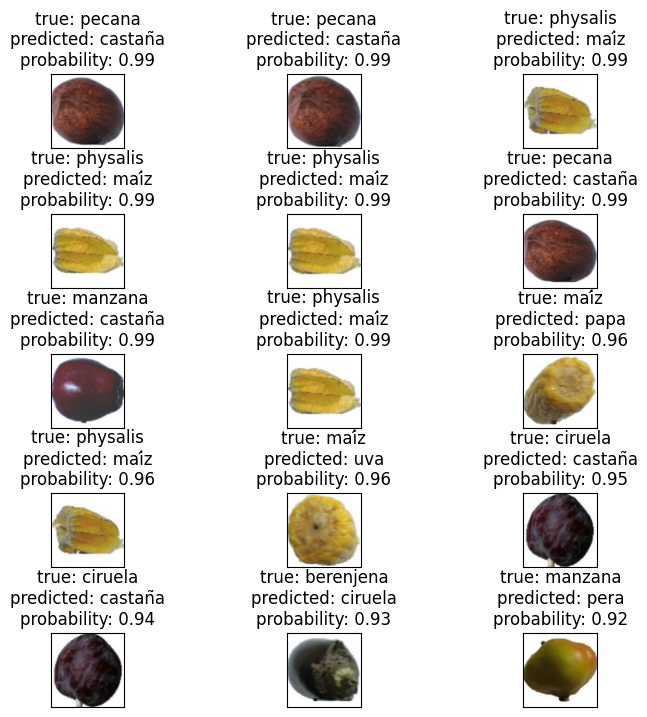

In [15]:
def Sort(pred):
    pred.sort(key = lambda x: x[3]) #sort using prob
    return pred 
print(str(len(misclassified)/len(val_dataset)*100)+"% are misclassified")
sorted_pred = Sort(misclassified) #creates sorted list of descending probabilities
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(8, 7), subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    x_example, y_pred, y_example, prob = sorted_pred[-(i+1)]
    ax.imshow(x_example.permute(1, 2, 0))
    ax.set_title("true: "+y_example+"\npredicted: "+y_pred+"\nprobability: "+str(prob.item())[:4], fontsize = 12)
plt.tight_layout(pad=0.1)
plt.show()

Se genera una matriz de confusión como heatmap. Los valores en la diagonal, muestran el valor de la métrica *accuracy* para cada clase. Los valores diferentes de la diagonal representan cómo se han clasificado las clases como otra clase del dataset.

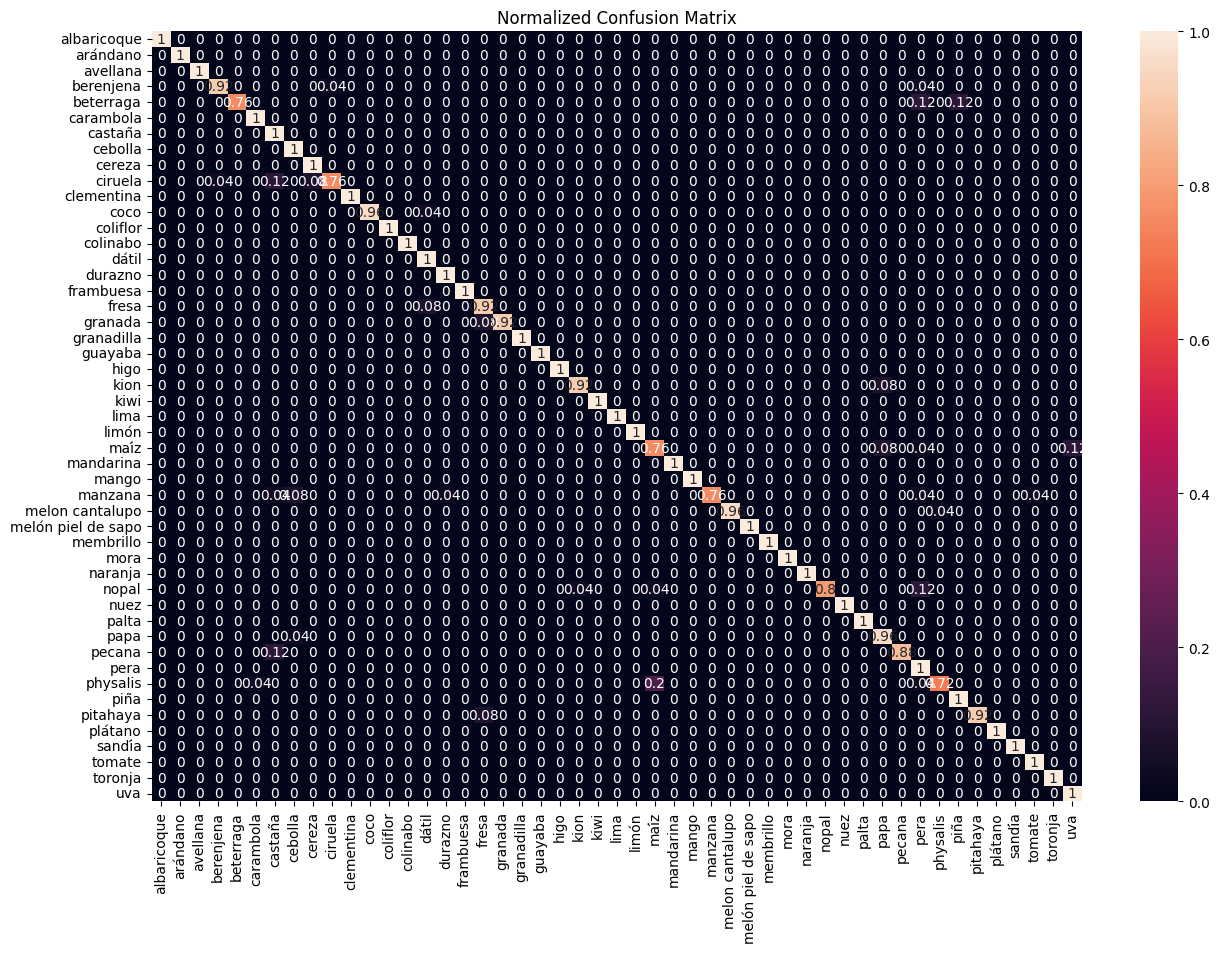

In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')
plt.figure(figsize = (15,10))
sns.heatmap(cf_matrix, 
            annot=True, 
            xticklabels = sorted(set(true_labels)), 
            yticklabels = sorted(set(true_labels)),
            )
plt.title('Normalized Confusion Matrix')
plt.show()

In [17]:
def predict(path):
    image = plt.imread(path)
    transform = transforms.Compose([transforms.ToPILImage(), transforms.Resize((224, 224)), transforms.ToTensor()])
    pil_img = (transform(image))
    with torch.no_grad():
        cnn_res_model.to(device)
        cnn_res_model.eval()
        logits = cnn_res_model(pil_img.unsqueeze(0).to(device))
        logits.squeeze().detach().cpu().numpy()
        y_hat = softmax(logits.cpu())
    return test_dataset.classes[int(np.argmax(y_hat))], pil_img